In [23]:
# Dependencies
import pandas as pd
import numpy as np

In [24]:
# Load data (FRED-MD)
df = pd.read_csv(
    '/home/js/macroeconvue/nowcasting/ML/data.csv',
    index_col='sasdate',
    parse_dates=True
)
# Normalize the dataframe
df = (df - df.mean()) / df.std()
# Get the target variable
target = df['CPIAUCSL'].copy()
# Drop the target 
df = df.drop(columns=['CPIAUCSL'])
# Dropna
df = df.dropna()

In [25]:
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA(n_components=0.90)
pca.fit(df)
data = pca.transform(df)

In [26]:
# Prepare data for the LSTM

# Convert data into sequences
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12  # Have one year of context
X, y = create_sequences(data, target.values, time_steps)

# # Split into train and test
split = len(X) - 12 # Last quarter for test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [27]:
# Build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

# Create model
model = Sequential([
    LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])

# Compile and train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=1)

# Evaluate
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/50


/home/js/macroeconvue/nowcasting/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.7256
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1058
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0808
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0689
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0662
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0661
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0654
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0425
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0499
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0505
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0438
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0424
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0339
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0380
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366
Epoch 16/50
12/12 ━━━━━━━━━━━

0.00027206019149161875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


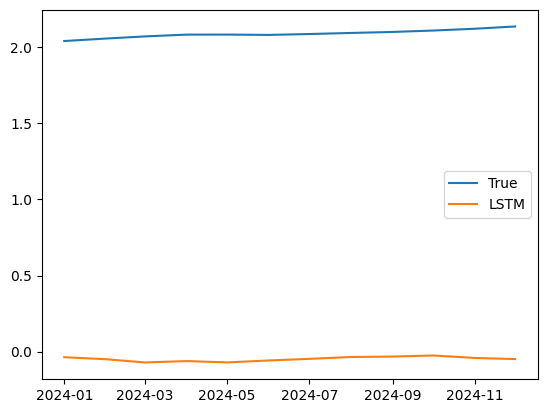

In [32]:
# Generate predictions and plot
import matplotlib.pyplot as plt

# Predictions
predictions = model.predict(X_test)
# Map predictions to index
predictions = pd.Series(predictions.ravel(), index=target.index[-12:])
# Normalize target
target = (target - target.mean()) / target.std()

# Plot
plt.plot(target[-12:], label='True')
plt.plot(predictions, label='LSTM')
plt.legend()
plt.show()